# TAREFA 5

Criar uma tabela com uma chave simples e alguns dados de exemplo. Cada valor de chave é um número
incremental e está associado a com valores que variam de 0 até 10

O que entregar: Imprimir os valores das 10 primeiras tuplas da tabela, ordenando por k.

Iniciar conexão com o banco de dados

In [1]:
!ps aux | grep "bin/postgres -D"


!lsof -i :5433
!kill -9 1419

!rm -rf ./meu_postgres
!/usr/lib/postgresql/14/bin/initdb -D ./meu_postgres 

!/usr/lib/postgresql/14/bin/pg_ctl -D ./meu_postgres  -o "-p 5433 -h 127.0.0.1 -c unix_socket_directories='.'" -l logfile start


#-h 127.0.0.1 -c unix_socket_directories='.'
#!psql -h localhost -p5433 postgres

# Executa o comando SQL (entre aspas) no banco de dados "postgres" na porta 5433
!/usr/lib/postgresql/14/bin/psql -h localhost -p 5433 -c "CREATE USER michael WITH PASSWORD 'mwpv0301';" postgres

!/usr/lib/postgresql/14/bin/psql -h localhost -p 5433 -c "CREATE DATABASE notebook_bd OWNER michael;" postgres

!/usr/lib/postgresql/14/bin/psql -h localhost -p 5433 -c "GRANT ALL PRIVILEGES ON DATABASE notebook_bd TO michael;" postgres




postgres    1366  0.0  0.1 220968 30336 ?        Ss   08:51   0:00 /usr/lib/postgresql/14/bin/postgres -D /var/lib/postgresql/14/main -c config_file=/etc/postgresql/14/main/postgresql.conf
icomp      18977  0.0  0.0   9984  3560 pts/2    Ss+  12:25   0:00 /bin/bash -c ps aux | grep "bin/postgres -D"
icomp      18979  0.0  0.0   9244  2388 pts/2    S+   12:25   0:00 grep bin/postgres -D


/bin/bash: linha 1: kill: (1419) - Operação não permitida
The files belonging to this database system will be owned by user "icomp".
This user must also own the server process.

The database cluster will be initialized with locale "pt_BR.UTF-8".
The default database encoding has accordingly been set to "UTF8".
The default text search configuration will be set to "portuguese".

Data page checksums are disabled.

creating directory ./meu_postgres ... ok
creating subdirectories ... ok
selecting dynamic shared memory implementation ... posix
selecting default max_connections ... 100
selecting default shared_buffers ... 128MB
selecting default time zone ... America/Manaus
creating configuration files ... ok
running bootstrap script ... ok
performing post-bootstrap initialization ... ok
syncing data to disk ... ok

initdb: warning: enabling "trust" authentication for local connections
You can change this by editing pg_hba.conf or using the option -A, or
--auth-local and --auth-host, the next

In [2]:
!/usr/lib/postgresql/14/bin/pg_ctl -D ./meu_postgres  -o "-p 5433" -l logfile start

waiting for server to start.... stopped waiting
pg_ctl: could not start server
Examine the log output.


In [ ]:
!python3 -m venv venv_projeto

In [ ]:
!source venv_projeto/bin/activate

In [4]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install psycopg2-binary

In [5]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [7]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Define a opção para mostrar TODAS as colunas, sem limite
pd.set_option('display.max_columns', None)

# Define a opção para mostrar TODAS as linhas, sem limite
pd.set_option('display.max_rows', None)


# Define a opção para mostrar o número máximo de elementos do array como infinito (None)
np.set_printoptions(threshold=np.inf)

In [3]:
import psycopg2

conn = psycopg2.connect(            
    dbname='notebook_bd',
    user='michael',
    password='mwpv0301',
    host='localhost',
    port='5433'
)


cursor = conn.cursor()


Criar as tabelas juntamente com os dados para o banco de dados local

In [4]:
conn.rollback()

cursor.execute("DROP TABLE IF EXISTS t;")
cursor.execute("""CREATE TABLE t (k serial PRIMARY KEY, v integer);
""")
cursor.execute("""
INSERT INTO t(v)
SELECT trunc(random() * 10) FROM generate_series(1,100000);
""") 

conn.commit()

Mostrar as 10 primeiras linhas da tabela aleatória criada

In [5]:
conn.rollback()

cursor.execute("""
SELECT * FROM t
ORDER BY k
LIMIT 10;
""")

columns = [desc[0] for desc in cursor.description]
resultados = cursor.fetchall()
df = pd.DataFrame(resultados, columns=columns)
display(df)

,k,v
0,1,7
1,2,0
2,3,6
3,4,3
4,5,3
5,6,0
6,7,1
7,8,0
8,9,3
9,10,0


# TAREFA 6

Verifique quantas páginas com blocos foram criadas para a tabela da Tarefa 5

In [8]:
cursor.execute("""
SELECT relname, relpages, reltuples FROM pg_class WHERE relname = 't';
""")
columns = [desc[0] for desc in cursor.description]
resultados = cursor.fetchall()
df = pd.DataFrame(resultados, columns=columns)
display(df)

,relname,relpages,reltuples
0,t,443,100000.0


# TAREFA 7

Verifique quantos blocos foram efetivamente usados numa consulta

COMO EXECUTAR OS COMANDOS VIA NOTEBOOK?

\pset x on                    -- modo expandido no psql (formatação visual)


\SELECT pg_stat_reset();       -- reseta estatísticas (precisas de sudo eu acho)


\pset x off

In [9]:
conn.rollback()

cursor.execute("""
SELECT pg_sleep(1);               
""")

cursor.execute("""
SELECT * FROM pg_stats WHERE tablename = 't';               
""")
columns = [desc[0] for desc in cursor.description]
resultados = cursor.fetchall()
df = pd.DataFrame(resultados, columns=columns)
display(df)

,schemaname,tablename,attname,inherited,null_frac,avg_width,n_distinct,most_common_vals,most_common_freqs,histogram_bounds,correlation,most_common_elems,most_common_elem_freqs,elem_count_histogram
0,public,t,k,False,0.0,4,-1.0,None,None,"{1,896,1913,2871,3902,4983,6035,7025,7966,8876...",1.000000,None,None,None
1,public,t,v,False,0.0,4,10.0,"{3,1,7,6,4,8,5,9,0,2}","[0.1018, 0.10126667, 0.10113333, 0.100833334, ...",None,0.098874,None,None,None


# TAREFA 17


In [10]:
import psycopg2
import random
import time
import threading
from psycopg2 import extensions, sql

# --- CONFIGURAÇÃO DO BANCO DE DADOS ---
DB_HOST = "localhost"
DB_NAME = "notebook_bd" 
DB_USER = "michael"
DB_PASS = "mwpv0301"
DB_PORT = "5433"

# Parâmetro de TOTAL_ASSENTO da Simulação
TOTAL_ASSENTOS = 10

In [21]:
class SistemaReservas:
    def __init__(self, isolation_level):
        """
        isolation_level: extensions.ISOLATION_LEVEL_READ_COMMITTED 
                         ou extensions.ISOLATION_LEVEL_SERIALIZABLE
        """
        self.isolation_level = isolation_level
        self.lock = threading.Lock() # Apenas para print thread-safe
        self.stats_lock = threading.Lock() # Para gravar estatísticas na lista
        self.clientes_atendidos = 0 # Contador global para controle do experimento
        self.retries_per_booking = []

    def get_connection(self):
        conn = psycopg2.connect(
            host=DB_HOST,
            database=DB_NAME,
            user=DB_USER,
            password=DB_PASS,
            port=DB_PORT
        )
        conn.set_isolation_level(self.isolation_level)
        return conn

    def setup_database(self):
        """Cria a tabela e popula com 200 assentos livres."""
        conn = psycopg2.connect(
            host=DB_HOST, database=DB_NAME, user=DB_USER, password=DB_PASS, port=DB_PORT
        )
        conn.set_isolation_level(extensions.ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        
        # Recria tabela limpa
        cur.execute("DROP TABLE IF EXISTS Assentos")
        cur.execute("""
            CREATE TABLE Assentos (
                num_voo INTEGER PRIMARY KEY,
                disp BOOLEAN NOT NULL DEFAULT TRUE
            )
        """)
        
        # Popula 200 assentos
        values = [(i, True) for i in range(1, TOTAL_ASSENTOS + 1)]
        args_str = ','.join(cur.mogrify("(%s, %s)", x).decode('utf-8') for x in values)
        cur.execute("INSERT INTO Assentos (num_voo, disp) VALUES " + args_str)
        
        print(f"Banco resetado: {TOTAL_ASSENTOS} assentos disponíveis.")
        cur.close()
        conn.close()

    def get_assentos_disponiveis(self, cur):
        """Passo 1: Recupera lista de assentos disponíveis."""
        cur.execute("SELECT num_voo FROM Assentos WHERE disp = TRUE")
        return [row[0] for row in cur.fetchall()]

    def realizar_reserva_versao_A(self, thread_id):
        """
        Versão A: Transação única englobando Passo 1, 2 e 3.
        O sleep(1) ocorre DENTRO da transação aberta.
        """
        conn = self.get_connection()
        try:
            cur = conn.cursor()
            
            # --- INÍCIO TRANSAÇÃO ---
            # (Em psycopg2, a transação inicia no primeiro comando se autocommit=False)
            
            # Passo 1: Recupera assentos
            assentos = self.get_assentos_disponiveis(cur)
            
            if not assentos:
                conn.rollback()
                return False # Sem assentos, encerra tentativa

            # Passo 2: Escolha do cliente (1 segundo de delay)
            assento_escolhido = random.choice(assentos)
            time.sleep(1) 

            # Passo 3: Atualiza
            # Importante: Verificamos 'disp=TRUE' novamente no UPDATE para garantir atomicidade 
            # lógica, embora a trava de linha (row lock) aconteça aqui.
            cur.execute(
                "UPDATE Assentos SET disp = FALSE WHERE num_voo = %s AND disp = TRUE",
                (assento_escolhido,)
            )
            
            if cur.rowcount > 0:
                conn.commit()
                return True # Sucesso
            else:
                # Alguém pegou o assento enquanto eu dormia
                conn.rollback()
                return False
                
        except psycopg2.extensions.TransactionRollbackError:
            # Captura erros de serialização (comuns no nível Serializable)
            conn.rollback()
            return False
        except Exception as e:
            print(f"Erro Thread {thread_id}: {e}")
            conn.rollback()
            return False
        finally:
            conn.close()

    def realizar_reserva_versao_B(self, thread_id):
        """
        Versão B: Duas transações.
        Tx1: Leitura.
        [Sem Tx]: Sleep(1).
        Tx2: Escrita.
        """
        # --- Transação 1: Leitura ---
        conn1 = self.get_connection()
        try:
            cur1 = conn1.cursor()
            assentos = self.get_assentos_disponiveis(cur1)
            conn1.commit() # Fim da Tx1
        except Exception as e:
            conn1.rollback()
            conn1.close()
            return False
        finally:
            conn1.close()

        if not assentos:
            return False

        # --- Passo 2: Fora de transação ---
        assento_escolhido = random.choice(assentos)
        time.sleep(1)

        # --- Transação 2: Escrita ---
        conn2 = self.get_connection()
        try:
            cur2 = conn2.cursor()
            # Tenta reservar. Se outro agente reservou no intervalo, rowcount será 0
            cur2.execute(
                "UPDATE Assentos SET disp = FALSE WHERE num_voo = %s AND disp = TRUE",
                (assento_escolhido,)
            )
            
            if cur2.rowcount > 0:
                conn2.commit()
                return True
            else:
                conn2.rollback()
                return False
        except Exception as e:
            # print(f"Erro T2 Thread {thread_id}: {e}")
            conn2.rollback()
            return False
        finally:
            conn2.close()

    def worker(self, thread_id, versao):
        """Função executada por cada thread (Agente)."""
        while True:
            # Verificação simples de parada: se já vendemos tudo
            # Nota: Em um cenário real de alta concorrência, consultar o DB seria melhor,
            # mas para simulação usamos um contador ou consultamos o banco se falhar muito.
            
            conn_check = self.get_connection()
            cur_check = conn_check.cursor()
            cur_check.execute("SELECT COUNT(*) FROM Assentos WHERE disp = FALSE")
            vendidos = cur_check.fetchone()[0]
            conn_check.close()
            
            if vendidos >= TOTAL_ASSENTOS:
                break

            # Tenta realizar reserva
            tentativas_falhas = 0
            sucesso = False

            # Tenta até conseguir reservar um assento para o "cliente atual"
            # Nota: O loop externo simula o agente pegando o próximo cliente.
            # Se a venda falha, o agente tenta de novo para o MESMO cliente.
            while not sucesso:
                # Verifica novamente condição de parada para não ficar em loop infinito no final
                if vendidos >= 200:
                    break
                if versao == 'a':
                    sucesso = self.realizar_reserva_versao_A(thread_id)
                else:
                    sucesso = self.realizar_reserva_versao_B(thread_id)
            
            
                if sucesso: 
                    with self.stats_lock:
                        self.retries_per_booking.append(tentativas_falhas)
                    break
                    
                else:
                    tentativas_falhas += 1
                    conn_check = self.get_connection()
                    conn_check.set_session(readonly=True, autocommit=True)
                    cur_check = conn_check.cursor()
                    cur_check.execute("SELECT COUNT(*) FROM Assentos WHERE disp = FALSE")
                    vendidos_atual = cur_check.fetchone()[0]
                    conn_check.close()

                    if vendidos_atual >= 200:
                        return
                    
                    time.sleep(0.01)

In [22]:
# --- EXECUÇÃO ---
def executar_experimento(NUM_AGENTES, VERSAO, NIVEL_ISOLAMENTO):
    print(f"--- Iniciando Experimento: Versão {VERSAO.upper()} | Agentes: {NUM_AGENTES} ---")

    sistema = SistemaReservas(NIVEL_ISOLAMENTO)
    sistema.setup_database() # Reseta a tabela para true

    print(f"Executando: Ver={VERSAO}, Iso={NIVEL_ISOLAMENTO}, Agentes={NUM_AGENTES}...", end=" ")
    
    start_time = time.time()
    threads = []
    for i in range(NUM_AGENTES):
        t = threading.Thread(target=sistema.worker, args=(i, VERSAO))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    end_time = time.time()
    tempo_total = end_time - start_time
    print(f"Feito em {tempo_total:.2f}s")


    print(f"\nExperimento Concluído!")
    print(f"Tempo Total: {tempo_total:.2f} segundos")

    # Validação final
    conn = sistema.get_connection()
    cur = conn.cursor()
    cur.execute("SELECT COUNT(*) FROM Assentos WHERE disp = FALSE")
    total_vendidos = cur.fetchone()[0]
    print(f"Total de assentos reservados no banco: {total_vendidos}/{TOTAL_ASSENTOS}")
    conn.close()

    return tempo_total, sistema.retries_per_booking

In [23]:
#agentes_list = [1, 2, 4, 6, 8, 10]
agentes_list = [1, 2]
versoes = ['a', 'b']
niveis_isolamento = [
    extensions.ISOLATION_LEVEL_READ_COMMITTED,
    extensions.ISOLATION_LEVEL_SERIALIZABLE
]
resultados_experimentos = []

for versao in versoes:
    for nivel in niveis_isolamento:
        nivel_nome = "Read Committed" if nivel == extensions.ISOLATION_LEVEL_READ_COMMITTED else "Serializable"
        
        for num_agentes in agentes_list:

            tempo, lista_retries = executar_experimento(num_agentes, versao, nivel)
            print()
            print()

            
            if lista_retries:
                min_retry = min(lista_retries)
                max_retry = max(lista_retries)
                avg_retry = sum(lista_retries) /len(lista_retries)
            else:
                min_retry, max_retry, avg_retry =0, 0, 0
            resultados_experimentos.append({
                'versao':versao,
                'isolamento':nivel_nome,
                'k_agentes':num_agentes,
                'tempo_total':tempo,
                'min_retry': min_retry,
                'max_retry':max_retry,
                'avg_retry':avg_retry
            })

#Cria um dataframe com todos os resultados para a análise
df_resultados = pd.DataFrame(resultados_experimentos)

Exception in thread Thread-17 (worker):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_18829/4291558448.py", line 198, in worker
psycopg2.errors.UndefinedTable: relation "assentos" does not exist
LINE 1: SELECT COUNT(*) FROM Assentos WHERE disp = FALSE
                             ^



--- Iniciando Experimento: Versão A | Agentes: 1 ---
Erro Thread 1: relation "assentos" does not exist
LINE 1: SELECT num_voo FROM Assentos WHERE disp = TRUE
                            ^

Banco resetado: 10 assentos disponíveis.
Executando: Ver=a, Iso=1, Agentes=1... Feito em 10.06s

Experimento Concluído!
Tempo Total: 10.06 segundos
Total de assentos reservados no banco: 10/10


--- Iniciando Experimento: Versão A | Agentes: 2 ---
Banco resetado: 10 assentos disponíveis.
Executando: Ver=a, Iso=1, Agentes=2... 

KeyboardInterrupt: 

# TAREFA 18: Graficos de linhas (Tempo vs Agentes)

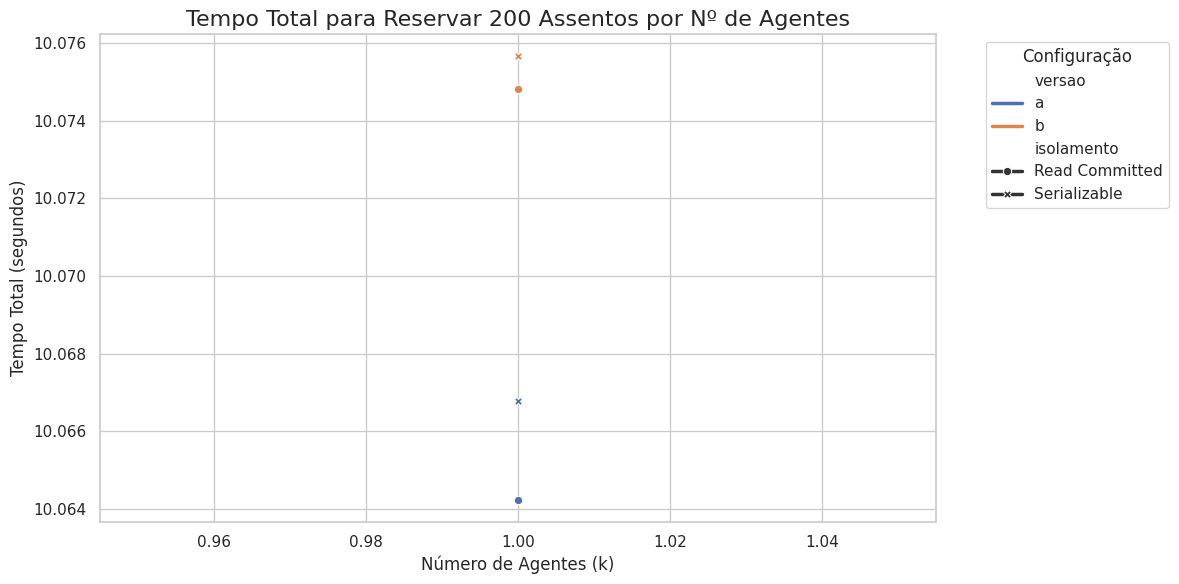

In [14]:
# Configuração visual
sns.set_theme(style="whitegrid")

# Criação dos gráficos
plt.figure(figsize=(12, 6))

# Podemos plotar tudo junto ou separar por isolamento. 
# O enunciado pede "Um gráfico diferente... para cada par de versões e nível".
# Interpretando: Podemos fazer 1 figura com 4 linhas ou subplots. 
# Abaixo, faço um gráfico único comparativo que é mais rico para análise.

sns.lineplot(
    data=df_resultados, 
    x='k_agentes', 
    y='tempo_total', 
    hue='versao', 
    style='isolamento',
    markers=True, 
    dashes=False,
    linewidth=2.5
)

plt.title('Tempo Total para Reservar 200 Assentos por Nº de Agentes', fontsize=16)
plt.xlabel('Número de Agentes (k)', fontsize=12)
plt.ylabel('Tempo Total (segundos)', fontsize=12)
plt.legend(title='Configuração', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# TAREFA 19: Tabela de Retentativas

In [ ]:
# Seleciona colunas relevantes e renomeia para apresentação
tabela_final = df_resultados[[
    'versao', 'isolamento', 'k_agentes', 
    'min_retry', 'max_retry', 'avg_retry'
]]

print("--- Tabela de Retentativas (Conflitos) ---")
# Exibe a tabela formatada (no Jupyter, basta chamar a variável tabela_final)
display(tabela_final)

# Opcional: Exportar para CSV ou LaTeX se precisar colocar no relatório
# tabela_final.to_csv('resultados_reservas.csv')